# Imports

In [4]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.build_features import *
from src.features.dataset import Dataset
from src.visualization.visualize import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
plt.rcParams.update({'font.size': 16})

from datetime import timedelta
from matplotlib.ticker import MaxNLocator# transition from acceptable to unhealthy for sensitive group and to unhealthy. 


Loading BokehJS ...

In [2]:
# transition from acceptable to unhealthy for sensitive group and to unhealthy. 
transition_dict = { 'PM2.5': [0, 35.5, 55.4, 1e3],
                  'PM10': [0, 155, 254, 1e3],
                  'O3':[0, 70 , 85, 1e3],
                  'SO2':[0, 75, 185, 1e3],
                  'NO2': [0, 100, 360, 1e3],
                  'CO': [0, 6.4, 12.5, 1e3]}

gas_list = ['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2']

city_info = {'Country': 'Thailand',
 'City': 'Chiang Mai',
 'City (ASCII)': 'Chiang Mai',
 'Region': 'Chiang Mai',
 'Region (ASCII)': 'Chiang Mai',
 'Population': '200952',
 'Latitude': '18.7904',
 'Longitude': '98.9847',
 'Time Zone': 'Asia/Bangkok'}

city_name = city_info['City'].lower().replace(' ', '_')

x = merc_x(city_info['Longitude'])
y = merc_y(city_info['Latitude'])

In [3]:
b_folder='../data/pm25/'
a4th_folder ='../data/air4thai_hourly/'
cm_folder ='../data/cm_proc/'
cdc_folder = '../data/cdc_data/'
aqm_folder = '../data/aqm_hourly2/'
model_folder = f'../models/{city_name}/'
if not os.path.exists(model_folder):
    os.mkdir(model_folder)

In [4]:
aqm1 = pd.read_csv(cm_folder + '35t.csv').set_index('datetime').dropna(how='all')
aqm1.index = pd.to_datetime(aqm1.index)
aqm2 = pd.read_csv(cm_folder + '36t.csv').set_index('datetime').dropna(how='all')
aqm2.index = pd.to_datetime(aqm2.index)
print(aqm2.columns)
# keep only the data after the satallite data which is 200-11-11 13 am
aqm2_01 = aqm2[aqm2.index>='2000-11-01 00:00:00'].copy()
aqm2_01 = add_season(aqm2_01)
print(aqm2_01.shape)

# weather data 
filename = 'C:/Users/Benny/Documents/Fern/aqi_thailand2/data/weather_cities/Mueang_Chiang_Mai.csv'
wea = pd.read_csv(filename)
wea.drop(['Time','Dew Point(C)','Wind Gust(kmph)','Pressure(in)','Precip.(in)'], axis=1, inplace=True)
wea['datetime'] = pd.to_datetime(wea['datetime'])
# merge with weather 

aqm2_01 = aqm2_01.merge(wea, left_index=True, right_on ='datetime',how='inner').set_index('datetime')
print(aqm2_01.shape)

Index(['CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5'], dtype='object')
(168337, 8)
(165459, 13)


In [5]:
fire = pd.read_csv('C:/Users/Benny/Documents/Fern/aqi_thailand2/data/cm_proc/file_m_proc.csv')
fire['datetime'] = pd.to_datetime(fire['datetime'])
fire = fire.set_index('datetime')
fire.head()

,confidence,lat_km,long_km,distance,power,count
datetime,,,,,,
2002-07-04 13:03:00,67,1612.0,11453.0,665.551109,120.96,1
2002-07-04 13:04:00,52,2246.0,11701.0,694.254989,20.52,1
2002-07-04 13:04:00,48,2304.0,11682.0,689.069015,13.50,1
2002-07-04 13:04:00,91,2305.0,11682.0,689.341767,132.30,1
2002-07-04 13:05:00,62,2428.0,11936.0,968.527252,10.45,1


In [6]:
# function for feature eng fire
def cal_power_damp(series: pd.core.series.Series, distance: pd.core.series.Series, surface='sphere'):
    """ Calculate the damped power based on the distance series. 

    The damping factor maybe 1/distance or 1/distance**2.
    Args: 
        series: series to recalculate
        distance: distance array. Must have the same lenght as the series
        surface(optional): either 'circle' or 'sphere'

    Returns:
        new_series

    Examples:
        cal_power_damp(fire['power'], fire['distance'],surface='sphere')

    """
    if surface == 'sphere':
        new_series = series/distance**2

    elif surface == 'circle':
        new_series = series/distance

    return new_series


def cal_arrival_time(detection_time: pd.core.series.Series, distance: pd.core.series.Series, wind_speed: (float, np.array) = 2):
    """ Calculate the approximate time that the pollution arrived at the city using the wind speed and distance from the hotspot.

    Round arrival time to hour 

    Args:
        detection_time: datetime series
        distance: distance series in km
        wind_speed(optional): approximate wind speed, can be floar or array in km/hour

    Returns: 
        arrival_time: datetime series of arrival time

    """
    arrival_time = detection_time + pd.to_timedelta(distance/wind_speed, 'h')
    return arrival_time.dt.round('H')


def shift_fire(fire_df: pd.core.frame.DataFrame, fire_col: str = 'power', damp_surface: str = 'sphere', shift: int = 0, roll: int = 48, w_speed: (float, int) = 8):
    """ Feature engineer fire data. Account of the distance from the source and time lag using wind speed.

    Args:
        fire_df:
        fire_col
        damp_surface
        shift
        roll

    """
    require_cols = ['distance', fire_col]
    if fire_df.columns.isin(require_cols).sum() > len(require_cols):
        raise AssertionError(
            'missing required columns for feature engineering fire data')

    # calculate the damping factors
    fire_df['damp_'+fire_col] = cal_power_damp(
        fire_df[fire_col], fire_df['distance'], surface=damp_surface)
    # calculate particle arrival time
    fire_df['arrival_time'] = cal_arrival_time(
        detection_time=fire_df.index, distance=fire_df['distance'], wind_speed=w_speed)
    fire_df = fire_df.set_index('arrival_time')
    fire_df = fire_df.resample('h').sum()['damp_'+fire_col]
    fire_df = fire_df.rolling(roll).sum()
    fire_df = fire_df.shift(shift)
    fire_df.index.name = 'datetime'
    return fire_df


def get_fire_feature(fire, zone_list=[0, 100, 200, 400, 800, 1000], fire_col: str = 'power', damp_surface: str = 'sphere', shift: int = 0, roll: int = 48, w_speed: (float, int) = 8):
    """ Separate fire from different distance

    """
    fire_col_list = []
    new_fire = pd.DataFrame()
    for start, stop in zip(zone_list, zone_list[1:]):
        col_name = f'fire_{start}_{stop}'

        fire_col_list.append(col_name)
        # select sub-data baseline the distance
        fire_s = fire[(fire['distance'] < stop) & (fire['distance'] >= start)][[fire_col, 'distance']].copy()
        fire_s = shift_fire(fire_s, fire_col=fire_col, damp_surface=damp_surface,
                            shift=shift, roll=roll, w_speed=w_speed)
        fire_s.name = col_name
        new_fire = pd.concat([new_fire, fire_s], axis=1, ignore_index=False)

    new_fire = new_fire.fillna(0)
    return new_fire, fire_col_list

def sep_fire_zone(fire, fire_col, zone_list=[0, 100, 200, 400, 800, 1000]):
    """ Separate fire data into zone mark by a distance in the zone_list without perform feature enginering.
    Use for data visualization
    
    Args: 
        fire: fire dataframe
        fire_col: 'power' or 'count'
        zone_list:
        
    Return: 
        new_fire: a dataframe with each column, a fire data in that zone
        fire_col_list: a list of column name
    
    """
    fire_col_list = []
    new_fire = pd.DataFrame()
    for start, stop in zip(zone_list, zone_list[1:]):
        col_name = f'fire_{start}_{stop}'
        fire_col_list.append(col_name)
        # select sub-data baseline the distance
        fire_s = fire[(fire['distance'] < stop) & (fire['distance'] >= start)][[fire_col]].copy()
        fire_s.columns = [col_name]
        fire_s = fire_s.resample('h').sum()
        new_fire = pd.concat([new_fire, fire_s], axis=1, ignore_index=False)

    return new_fire, fire_col_list

In [7]:
fire_dict = {'fire_col': 'power',
 'surface': 'sphere',
 'w_speed': 10,
 'shift': -24,
 'roll': 72}

In [8]:
def split_data_index(data_index, shuffle=False,val_size=0.3, test_size=0.25):
    trn, test = train_test_split(data_index, test_size=test_size, shuffle=False)
    trn, val  = train_test_split(trn, test_size=val_size, shuffle=False)
    print('train size', len(trn))
    print('validation size',len(val))
    print('test size',len(test))
    return trn,  val, test

def get_data_matrix(data, pollutant,use_index, x_cols=[]):
    """Extract data in data dataframe into x,y matricies using use_index.
    
    """
    temp = data.loc[use_index]
    
    y = temp[pollutant].values
    
    if len(x_cols)==0:
        x = temp.drop(pollutant,axis=1)
    else:
        x = temp[x_cols]
        
    x_cols = x.columns
    return x.values, y, x_cols

# Add AutoRegressive Feature

# calculate number of lag 
def find_num_lag(poll_series, thres=0.5):
    """ Calculate the numbers of partial autocorrelation lag to add as feature to a time series. 
    
    """

    pac = pacf(poll_series)
    # find the number of lag 
    idxs = np.where(pac >= 0.5)[0]
    return idxs[1:]

def add_lags(data, pollutant):
    """Add lags columns to x_data.

    """
    # calculate num lags
    num_lags = find_num_lag(data[pollutant])
    for idx in num_lags:
        lag_name = f'{pollutant}_lag_{idx}'
        lag_series = data[pollutant].shift(idx) 
        lag_series.name = lag_name
        # add to data 
        data = pd.concat([data, lag_series], axis=1) 
    data = data.dropna()
    return data

In [9]:
# load the data and keep only relavant data 
pollutant = 'PM2.5'
cols = [pollutant, 'Temperature(C)', 'Humidity(%)', 'Wind', 'Wind Speed(kmph)', 'Condition']
data = aqm2_01[cols].dropna()

if pollutant == 'PM2.5':
    data = data.loc['2010':]

# add weather 
dummies = wind_to_dummies(data['Wind'])
data.drop('Wind',axis=1, inplace=True)
data = pd.concat([data, dummies], axis=1)
data = add_is_rain(data)
data = add_calendar_info(data)
data = add_lags(data, pollutant)
data_no_fire = data.astype(float)


In [10]:
# split data index 
# because will be building new feature later in the pipeline, therefore only need index here.
trn_idx, val_idx, test_idx = split_data_index(data.index,shuffle=False, val_size=0.4, test_size=0.3)
# split furture for rf 
trn_rf_idx, val_rf_idx = train_test_split(trn_idx,test_size=0.35)

train size 31401
validation size 20935
test size 22431


In [11]:
# implement the best parameters 
fire_col = fire_dict['fire_col']
w_speed = fire_dict['w_speed']
damp_surface = fire_dict['surface']
shift = fire_dict['shift']
roll = fire_dict['roll']
# obtain fire data 
fire_proc, fire_col_list = get_fire_feature(fire, zone_list=[0, 100, 200, 400, 800, 1000], 
fire_col=fire_col,damp_surface=damp_surface, 
shift=shift, roll=roll, w_speed=w_speed)
 
# merge fire data 
data = data_no_fire.merge(fire_proc, left_index=True, right_index=True, how='inner')
data = data.dropna()
 
x_cols = ['Wind Speed(kmph)', 'Temperature(C)', 'Humidity(%)', 'time_of_day',
       'fire_400_800', 'fire_800_1000', 'fire_200_400', 'fire_0_100',
       'fire_100_200', 'PM2.5_lag_1']
xtrn, ytrn, x_cols = get_data_matrix(data, pollutant,trn_idx, x_cols=x_cols)
xval, yval, _ = get_data_matrix(data, pollutant,val_idx, x_cols=x_cols)

In [12]:
#ask TPOT to hunt for the best model
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(xtrn, ytrn)


Generation 1 - Current best internal CV score: -118.70543593428506
Generation 2 - Current best internal CV score: -118.70543593428506
Generation 3 - Current best internal CV score: -118.70543593428506
Generation 4 - Current best internal CV score: -118.70543593428506
Generation 5 - Current best internal CV score: -118.70543593428506
Best pipeline: XGBRegressor(AdaBoostRegressor(input_matrix, learning_rate=0.01, loss=linear, n_estimators=100), learning_rate=0.1, max_depth=3, min_child_weight=13, n_estimators=100, nthread=1, objective=reg:squarederror, subsample=0.7000000000000001)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=None, generations=5,
              log_file=<ipykernel.iostream.OutStream object at 0x00000189E2DF4088>,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=50,
              random_state=None, scoring=None, subsample=1.0, template=None,
              use_dask=False, verbosity=2, warm_start=False)

In [14]:
print(tpot.score(xval,yval))
tpot.export('tpot_pipeline.py')

-62.410713640603696


# Model Diff

In [5]:
data = Dataset('Chiang Mai')
data.load_()
data.pollutant = 'PM2.5'
# build the first dataset 
data.feature_no_fire()
data.make_diff_col()
# use default fire feature
data.merge_fire()
x_cols = data.data.columns.drop([data.pollutant, data.monitor ] )
print(x_cols)

data no fire has shape (77746, 15)
use default fire feature
Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday',
       'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='object')


In [7]:
# step 1 get the first model 
tpot = TPOTRegressor( generations=5, population_size=50, verbosity=2,  n_jobs=-1)

tpot.fit(xtrn, ytrn)
tpot_model = tpot.fitted_pipeline_

score_dict = cal_scores(yval, tpot_model.predict(xval), header_str ='val_')
print('optimize 1 score', score_dict)

feat_imp = feat_importance(tpot_model,xtrn,ytrn,x_cols,n_iter=50)
show_fea_imp(feat_imp, title='tpot feature of importance(raw)')


Generation 1 - Current best internal CV score: -131.4078404768572
Generation 2 - Current best internal CV score: -131.4078404768572
Generation 3 - Current best internal CV score: -131.38862006323808
Generation 4 - Current best internal CV score: -131.38862006323808
Generation 5 - Current best internal CV score: -131.31878184266944
Best pipeline: ExtraTreesRegressor(ElasticNetCV(input_matrix, l1_ratio=0.8500000000000001, tol=0.0001), bootstrap=True, max_features=0.45, min_samples_leaf=17, min_samples_split=13, n_estimators=100)
optimize 1 score {'val_r2_score': 0.06138123829141895, 'val_mean_squared_error': 39.79195583609111}


17it [05:52, 20.75s/it]


NameError: name 'feat_imp' is not defined

optimize 1 score {'val_r2_score': 0.06138123829141895, 'val_mean_squared_error': 39.79195583609111}


17it [06:12, 21.93s/it]


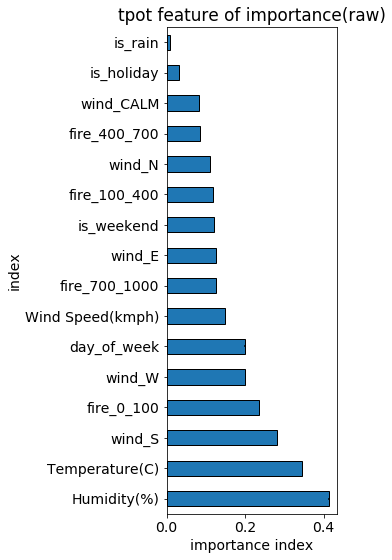

In [9]:
print('optimize 1 score', score_dict)

feat_imp = feat_importance(tpot_model,xtrn,ytrn,x_cols,n_iter=50)
show_fea_imp(feat_imp, title='tpot feature of importance(raw)')

In [10]:
tpot.export(data.model_folder + 'diff_tpot.py')
pickle.dump(tpot_model, open(data.model_folder +f'PM25diff_tpot_model.pkl', 'wb'))

In [11]:
x_cols

Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday',
       'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='object')

In [13]:
model = tpot_model

In [14]:
print('=================optimize 2: remove unncessary columns=================')
# columns to consider droping are columns with low importance
to_drop = feat_imp['index']
to_drop = [a for a in to_drop if 'fire' not in a]

for s in ['Humidity(%)','Temperature(C)','Wind Speed(kmph)']:
    to_drop.remove(s)

to_drop.reverse()
model, new_x_cols = reduce_cols(dataset=data, x_cols=x_cols,to_drop=to_drop,model=model,trn_i=0, val_i=1)
data.x_cols = new_x_cols

=================optimize 2: remove unncessary columns=================
old cols Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday',
       'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='object')
drop is_rain
drop is_holiday
drop wind_CALM
drop wind_N
drop wind_E
drop day_of_week
use columns Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_S', 'wind_W',
       'is_weekend', 'time_of_day', 'fire_0_100', 'fire_100_400',
       'fire_400_700', 'fire_700_1000'],
      dtype='object')
r2_score after dropping columns 0.06863488528334682


In [15]:
print('================= optimization 3: find the best fire feature ===================')
# reduce the number of split
data.split_data(split_ratio=[0.6, 0.2, 0.2])
data.fire_dict = sk_op_fire(data, model, trn_index=data.split_list[0], val_index=data.split_list[1])
print(data.fire_dict)

================= optimization 3: find the best fire feature ===================
skop_ fire use x_cols Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_S', 'wind_W',
       'is_weekend', 'time_of_day', 'fire_0_100', 'fire_100_400',
       'fire_400_700', 'fire_700_1000'],
      dtype='object')
old score 0.07208103261117216 fire dict {'w_speed': 4, 'shift': -24, 'roll': 108}
optimizing fire parameter using skopt optimizer. This will take about 20 mins
r2 score for the best fire parameters 0.07886690847744404
{'w_speed': 2, 'shift': 48, 'roll': 120}


In [16]:
print('================= optimization 4: optimize for the best RF again and search for other model in TPOT =================')

data.split_data(split_ratio=[0.7, 0.3])
trn_index = data.split_list[0]
test_index = data.split_list[1]
fire_cols = data.merge_fire(data.fire_dict)
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=trn_index,x_cols=new_x_cols)
xtest, ytest, _ = data.get_data_matrix(use_index=test_index,x_cols=new_x_cols)

tpot.fit(xtrn, ytrn)
tpot_model = tpot.fitted_pipeline_

score_dict = cal_scores(ytest, model.predict(xtest), header_str ='test_')
print(score_dict)
tpot.export(data.model_folder + 'diff_tpot.py')
pickle.dump(tpot_model, open(data.model_folder +f'PM25diff_tpot_model.pkl', 'wb'))

================= optimization 4: optimize for the best RF again and search for other model in TPOT =================



Generation 1 - Current best internal CV score: -88.48223340425884
Generation 2 - Current best internal CV score: -88.43795177952782
Generation 3 - Current best internal CV score: -88.43795177952782
Generation 4 - Current best internal CV score: -88.42077363148196
Generation 5 - Current best internal CV score: -88.42077363148196
Best pipeline: ExtraTreesRegressor(CombineDFs(input_matrix, input_matrix), bootstrap=True, max_features=0.35000000000000003, min_samples_leaf=11, min_samples_split=11, n_estimators=100)
{'test_r2_score': 0.09880185694260102, 'test_mean_squared_error': 24.7764119325055}


Text(0, 0.5, 'PM2.5')

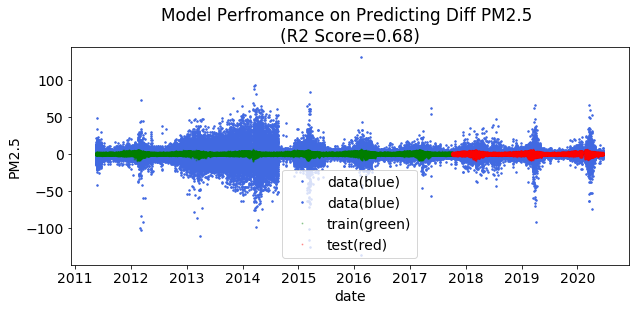

In [18]:
plt.figure(figsize=(10, 4))
  
# plot data 
plt.plot(trn_index,ytrn, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')
plt.plot(test_index,ytest, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')

plt.plot(trn_index,model.predict(xtrn), marker='.', label='train(green)',linewidth=0,alpha=0.3, markersize=2,color='green')
plt.plot(test_index,model.predict(xtest), marker='.', label='test(red)',linewidth=0,alpha=0.3, markersize=2, color='red')
 
plt.legend()
plt.title('Model Perfromance on Predicting Diff PM2.5 \n(R2 Score=0.68)')
plt.xlabel('date')
plt.ylabel('PM2.5')